**Segmentasi dan Cropping 1 Citra - Banyak Objek**

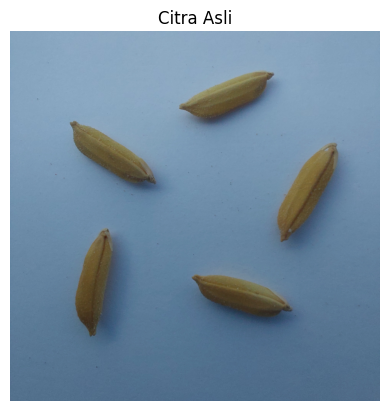

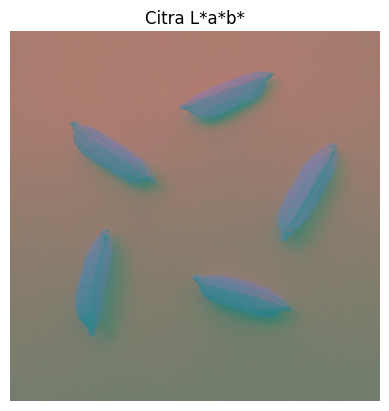

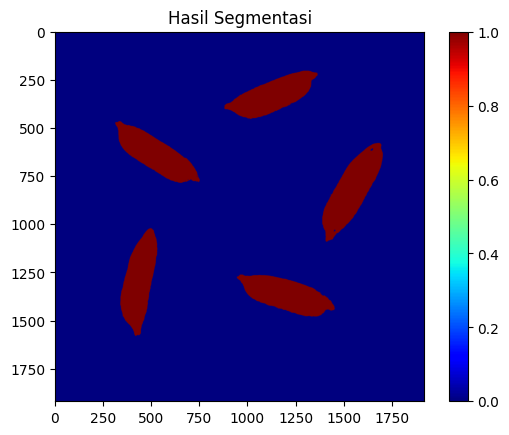

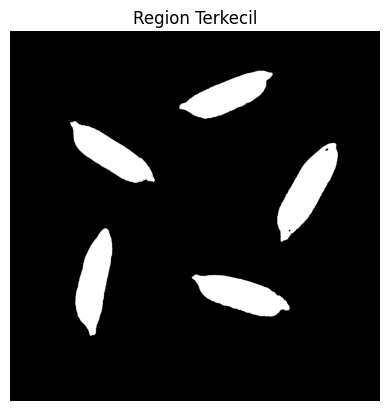

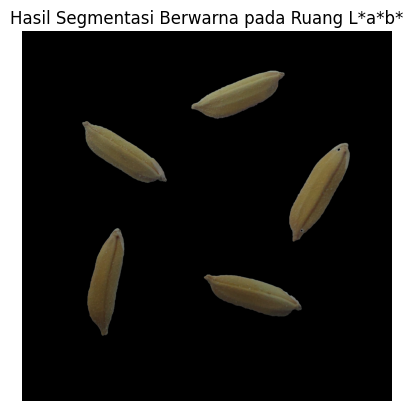

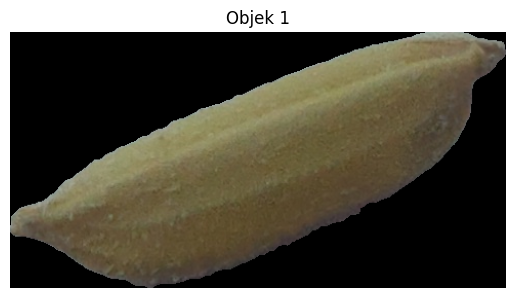

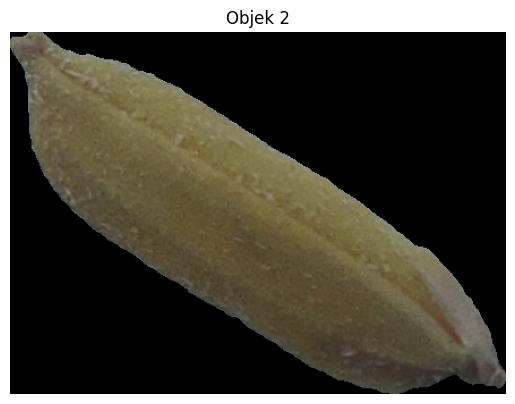

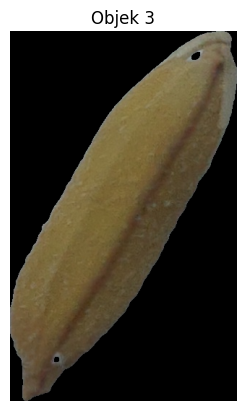

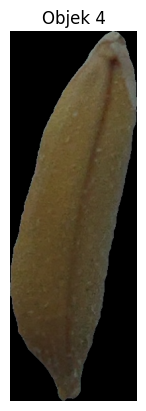

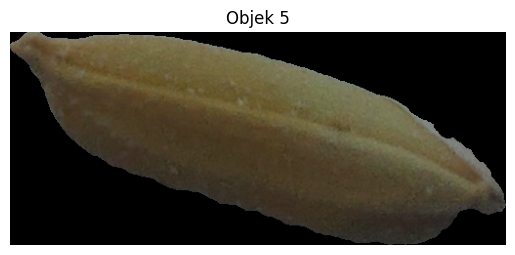

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import measure

# Membaca citra RGB
img = cv2.imread('ch (1).jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
plt.figure()
plt.imshow(img_rgb)
plt.title('Citra Asli')
plt.axis('off')
plt.savefig('gambar_asli.png')  # Simpan gambar asli dalam file PNG

# Mengonversi citra RGB ke ruang warna L*a*b*
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)  # Konversi citra ke L*a*b*
plt.figure()
plt.imshow(lab_image)
plt.title('Citra L*a*b*')
plt.axis('off')
plt.savefig('gambar_lab.png')  # Simpan citra L*a*b*

# Mengekstrak L*, a*, dan b* ke dalam vektor untuk K-means clustering
ab = lab_image[:, :, 1:3].astype(float)  # Menggunakan komponen a* dan b*
ab = ab.reshape(-1, 2)  # Ubah menjadi format data yang sesuai untuk K-means

# Segmentasi citra menggunakan K-means clustering
number_of_classes = 2
kmeans = KMeans(n_clusters=number_of_classes, random_state=0)
kmeans.fit(ab)  # Lakukan K-means clustering
pixel_labels = kmeans.labels_.reshape(lab_image.shape[:2])  # Reshape ke ukuran citra asli

# Tampilkan hasil segmentasi
plt.figure()
plt.imshow(pixel_labels, cmap='jet')
plt.title('Hasil Segmentasi')
plt.colorbar()
plt.savefig('segmentasi_lab.png')  # Simpan hasil segmentasi L*a*b*

# Menemukan kelas dengan area terkecil
area = np.bincount(pixel_labels.ravel())
min_area_class = np.argmin(area)

# Pemilihan objek berdasarkan region terkecil
object_mask = pixel_labels == min_area_class
plt.figure()
plt.imshow(object_mask, cmap='gray')
plt.title('Region Terkecil')
plt.axis('off')
plt.savefig('region_terkecil_lab.png')  # Simpan region terkecil dari hasil K-means

# Filter median untuk penghalusan
bw = cv2.medianBlur(object_mask.astype(np.uint8) * 255, 5)  # Penghalusan dengan median filter

# Menghilangkan area kecil
num_labels, labels_im = cv2.connectedComponents(bw)
min_size = 200  # Ubah threshold sesuai kebutuhan
filtered_mask = np.zeros_like(bw)

for label in range(1, num_labels):
    if np.sum(labels_im == label) >= min_size:# label_im memberi label unik pada warna (sama) yang dipisahkan oleh warna lain
        filtered_mask[labels_im == label] = 255

# Isi lubang atau area kosong dalam objek
filtered_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

# Hasil segmentasi berwarna dengan latar belakang hitam
segmented_image = np.zeros_like(img_rgb)  # Mulai dengan latar belakang hitam
segmented_image[filtered_mask.astype(bool)] = img_rgb[filtered_mask.astype(bool)]  # Mengisi objek yang tersegmentasi

# Tampilkan hasil segmentasi berwarna
plt.figure()
plt.imshow(segmented_image)
plt.title('Hasil Segmentasi Berwarna pada Ruang L*a*b*')
plt.axis('off')
plt.savefig('hasil_segmentasi_lab.png')  # Simpan hasil segmentasi berwarna

# Pemisahan masing-masing objek
labeled_bw = measure.label(filtered_mask, connectivity=2)  # Labeling objek
#connectivity=2 (alias 8-konektivitas) berarti piksel dianggap saling terhubung jika mereka bersentuhan secara diagonal, horizontal, atau vertikal.
stats = measure.regionprops(labeled_bw)

# Menyimpan setiap objek yang terdeteksi
for i, region in enumerate(stats):
    # Mendapatkan kotak pembatas untuk setiap objek
    min_row, min_col, max_row, max_col = region.bbox

    # Memotong objek dari citra asli
    object_i = segmented_image[min_row:max_row, min_col:max_col]

    # Cek apakah objek tidak kosong
    if object_i.size > 0:
        plt.figure()
        plt.imshow(object_i)
        plt.title(f'Objek {i + 1}')
        plt.axis('off')

        # Simpan objek yang terdeteksi
        filename = f'object_{i + 1}.png'
        plt.savefig(filename)  # Simpan gambar objek

plt.show()  # Tampilkan semua gambar yang dihasilkan


**Segmentasi dan Cropping Semua Folder - banyak objek**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Daftar folder untuk setiap jenis padi
folders = {
    #'ciherang': '/content/drive/MyDrive/CNN/Padi/Cropping/Sebelum/Ciherang',
    #'inpari': '/content/drive/MyDrive/CNN/Padi/Cropping/Sebelum/Inpari',
    'sintanur': '/content/drive/MyDrive/CNN/Padi/Cropping/Sebelum/Sintanur'
}

# Folder output untuk hasil segmentasi
output_folders = {
  #  'ciherang': '/content/drive/MyDrive/CNN/Padi/Cropping/Setelah/Ciherang',
    #'inpari': '/content/drive/MyDrive/CNN/Padi/Cropping/Setelah/Inpari',
    'sintanur': '/content/drive/MyDrive/CNN/Padi/Cropping/Setelah/Sintanur'
}

# Membuat folder output jika belum ada
for folder in output_folders.values():
    if not os.path.exists(folder):
        os.makedirs(folder)

# Fungsi untuk memproses setiap gambar
def process_image(image_path, output_folder):
    # Membaca citra
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB

    # Mengonversi citra ke ruang warna L*a*b*
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

    # Mengekstrak komponen a* dan b*
    a_channel = lab_image[:, :, 1]
    b_channel = lab_image[:, :, 2]

    # Menggabungkan kedua saluran
    ab = np.stack((a_channel, b_channel), axis=-1)

    # Menggunakan K-means clustering untuk segmentasi
    num_classes = 2
    ab_reshaped = ab.reshape((-1, 2))
    kmeans = cv2.kmeans(ab_reshaped.astype(np.float32), num_classes, None,
                        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                        10, cv2.KMEANS_RANDOM_CENTERS)[1]

    # Mengubah kembali hasil clustering ke ukuran citra asli
    segmented_img = kmeans.reshape(img.shape[:2])

    # Menemukan kelas dengan area terkecil
    area = [np.sum(segmented_img == i) for i in range(num_classes)]
    min_area_class = np.argmin(area)

    # Memilih objek berdasarkan region terkecil
    object_mask = segmented_img == min_area_class

    # Filter median untuk penghalusan
    object_mask = cv2.medianBlur(object_mask.astype(np.uint8) * 255, 5)

    # Hapus area kecil yang tidak diinginkan
    num_labels, labels_im = cv2.connectedComponents(object_mask)

    # Menggunakan fungsi bwareaopen untuk menghapus objek kecil
    min_size = 2000  # Ubah threshold sesuai kebutuhan
    filtered_mask = np.zeros_like(object_mask)
    for label in range(1, num_labels):
        if np.sum(labels_im == label) >= min_size:
            filtered_mask[labels_im == label] = 1

    # Isi lubang atau area kosong dalam objek
    filtered_mask = cv2.morphologyEx(filtered_mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5, 5)))

    # Hasil segmentasi berwarna dengan latar belakang hitam
    segmented_image = np.zeros_like(img_rgb)
    segmented_image[filtered_mask.astype(bool)] = img_rgb[filtered_mask.astype(bool)]

    # Pemisahan masing-masing objek
    contours, _ = cv2.findContours(filtered_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Proses setiap objek yang ditemukan
    for i, contour in enumerate(contours):
        # Mendapatkan bounding box dari setiap kontur
        x, y, w, h = cv2.boundingRect(contour)
        padi_i = segmented_image[y:y + h, x:x + w]  # Memotong objek dari citra hasil segmentasi

        # Menampilkan dan menyimpan hasil cropping untuk setiap objek
        if padi_i.size > 0:
            plt.figure(figsize=(5, 5))
            plt.imshow(padi_i)
            plt.axis('off')

            # Simpan gambar objek dengan nama yang unik
            filename_png = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(image_path))[0]}_{i + 1}.png')
            plt.savefig(filename_png, bbox_inches='tight', pad_inches=0)
            plt.show()

# Iterasi melalui setiap folder dan gambar
for key, folder in folders.items():
    # Mendapatkan daftar file gambar dalam folder
    image_files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    output_folder = output_folders[key]  # Ambil folder output yang sesuai

    # Iterasi melalui semua gambar dalam folder
    for image_file in image_files:
        image_path = os.path.join(folder, image_file)
        print(f'Processing: {image_path}')
        process_image(image_path, output_folder)
